### Pre-eruptive ground deformation at Kīlauea ###

#### Supplementary to Farquharson and Amelung (2020), doi: [10.1038/s41586-020-2172-5](https://doi.org/10.1038/s41586-020-2172-5)

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines
import matplotlib.transforms as transforms
import matplotlib
matplotlib.rc('text', usetex = True)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import ConnectionPatch, Polygon
from matplotlib import patheffects
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import datetime as dt
import calendar
import geopandas as gpd
import pandas as pd
import numpy as np
import string as STRING
import warnings
warnings.filterwarnings('ignore')
import os

print("All packages imported")

All packages imported


In [2]:
# from mintpy.simulation.plot import *
# from mintpy.objects import sensor
from mintpy.utils import readfile, plot as pp, utils as ut
from mintpy import view
from mintpy.objects.gps import search_gps, GPS

In [3]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)

In [4]:
'''
Function retreives GPS vectors.
'''

def gps_vectors(datestring, SNWE, proj_name = "kilauea"):
    SNWE = SNWE
    date12 = datestring

    start_date, end_date = date12.split('_')
    print_msg = False

    proj_name = proj_name

    from mintpy.objects.gps import search_gps, GPS
    site_names, site_lats, site_lons = search_gps(SNWE, start_date, end_date)
    num_site = len(site_names)
    print('reading GPS displacement between {} and {} ...'.format(start_date, end_date))
    gps_dis, gps_lats, gps_lons, gps_names = [], [], [], []
    for i in range(num_site):
        obj = GPS(site_names[i])
        dis0 = np.array(obj.read_displacement(start_date, start_date, print_msg=print_msg)[1:]) * 100.
        dis1 = np.array(obj.read_displacement(end_date,   end_date,   print_msg=print_msg)[1:]) * 100.
        if all(i[0].size != 0 for i in [dis0, dis1]):
            dis = dis1 - dis0
            dis[3:] = (dis1[3:]**2 + dis0[3:]**2)**0.5
            gps_dis.append(dis)
            gps_lats.append(site_lats[i])
            gps_lons.append(site_lons[i])
            gps_names.append(site_names[i])
    gps_dis = np.squeeze(np.array(gps_dis))
    gps_lats = np.array(gps_lats)
    gps_lons = np.array(gps_lons)
    gps_names = np.array(gps_names)

    ##  Save GPS data to text file in GEODMOD format
    txt_file = 'GPS_{}_{}.txt'.format(proj_name, date12) #os.path.join(work_dir, 'GPS_{}_{}.txt'.format(proj_name, date12))
    f = open(txt_file, 'w')
    f.write('#Site   lat/deg     lon/deg    Nvel/cm    Nerr/cm   Evel/cm   Nerr/cm   Uvel/cm   Uerr/cm\n')
    for i in range(len(gps_names)):
        fmt = '  '.join(['{}'] + ['{:10.05f}']*2 + ['{:8.2f}']*6)
        line = fmt.format(gps_names[i],
                          gps_lats[i], gps_lons[i],
                          gps_dis[i,1], gps_dis[i,4],
                          gps_dis[i,0], gps_dis[i,3],
                          gps_dis[i,2], gps_dis[i,5])
        f.write(line+'\n')
    f.close()

    ## Read GPS data from text file
    fc = np.loadtxt(txt_file, dtype=bytes).astype(str)
    gps_names = fc[:,0]
    gps_lats = fc[:,1].astype(np.float)
    gps_lons = fc[:,2].astype(np.float)
    dis_n = fc[:,3].astype(np.float).reshape(-1,1)
    dis_e = fc[:,5].astype(np.float).reshape(-1,1)
    dis_u = fc[:,7].astype(np.float).reshape(-1,1)
    
    return dis_n, dis_e, dis_u, gps_lats, gps_lons, gps_names

In [31]:
import os
from os import path
os.getcwd()
!pwd
if not os.path.exists('work_dir'):
    os.mkdir('work_dir')
else:
    print("'work_dir' directory already exists'")
work_dir = os.path.expanduser('work_dir')
p
'''
Access and download .h5 and DEM files from Zenodo [doi: 10.5281/zenodo.3459589]
'''

!wget -nv -O srtm 'https://zenodo.org/record/3459589/files/srtm1_msk.dem?download=1' -nc -c   
# !wget -nv -O vel_1517 'https://zenodo.org/record/3459589/files/up_2015_2017.h5?download=1' -nc -c   
# !wget -nv -O vel_18 'https://zenodo.org/record/3459589/files/up_2018.h5?download=1' -nc -c  

srtm = os.path.expanduser(work_dir+'/srtm')

print("all files accessed")

/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk/data/work_dir
'work_dir' directory already exists'
2020-07-15 21:32:41 URL:https://zenodo.org/record/3459589/files/srtm1_msk.dem?download=1 [155520000/155520000] -> "srtm" [1]
all files accessed


In [48]:
kil_lalo = (19.421, -155.287) ## kilauea coordinates
pu_lalo = (19.3864,-155.1050) ## pu`u `O`o coordinates

ts_file_asc = "../../../Kilauea_ts/KilaueaSenAT124/mintpy_0.0004/geo/geo_timeseries_tropHgt_demErr.h5" ## Ascending data
ts_file_desc = "../../../Kilauea_ts/KilaueaSenDT87/mintpy_0.0004/geo/geo_timeseries_tropHgt_demErr.h5" ## Descending data
up_file = "../../../Kilauea_ts/up_test4.h5" ## Vertical uplift calculated from Ascending and Descending
srtm = "../../../Kilauea_ts/srtm1.dem"
year_frac = (dt.datetime(2018,4,23) - dt.datetime(2018,3,15)).days/365

In [6]:
'''
Shapefile of Big Island faults: 
University of Hawaii. (2015). Hawaii Faults [data set].  Retrieved from http://gdr.openei.org/submissions/532.
'''
#os.chdir(filepath)
faults = gpd.read_file("../Hawaii_Faults.shp")

In [7]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3, fontsize = "x-small"):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=1)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize = fontsize)

In [27]:
W, N, E, S = (-155.35, 19.475, -155.05, 19.275)

fig = plt.figure(figsize=mm2inch(135, 135), dpi = 300) ## initiate figure
matplotlib.rc('text', usetex = True)
axs = []
for num in range(72):
    axs.append(plt.subplot(8,9,num+1,
    projection=ccrs.PlateCarree())
          )
# plt.clf()
cmd_ = 'view.py {} --noverbose --nodisplay'.format(ts_file_asc)
_, _ ,inps_ = view.prep_slice(cmd_)
for i, dset in enumerate(inps_.dset):
    subset = dset[-8::]
    ax = axs[i]
    cmd =  'view.py {} {} '.format(ts_file_asc, subset)
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c inferno --nocbar --vlim -10 10 '
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(srtm)
    cmd += '--noscalebar --notitle --fontsize 12 --ref-size 2 --noverbose'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

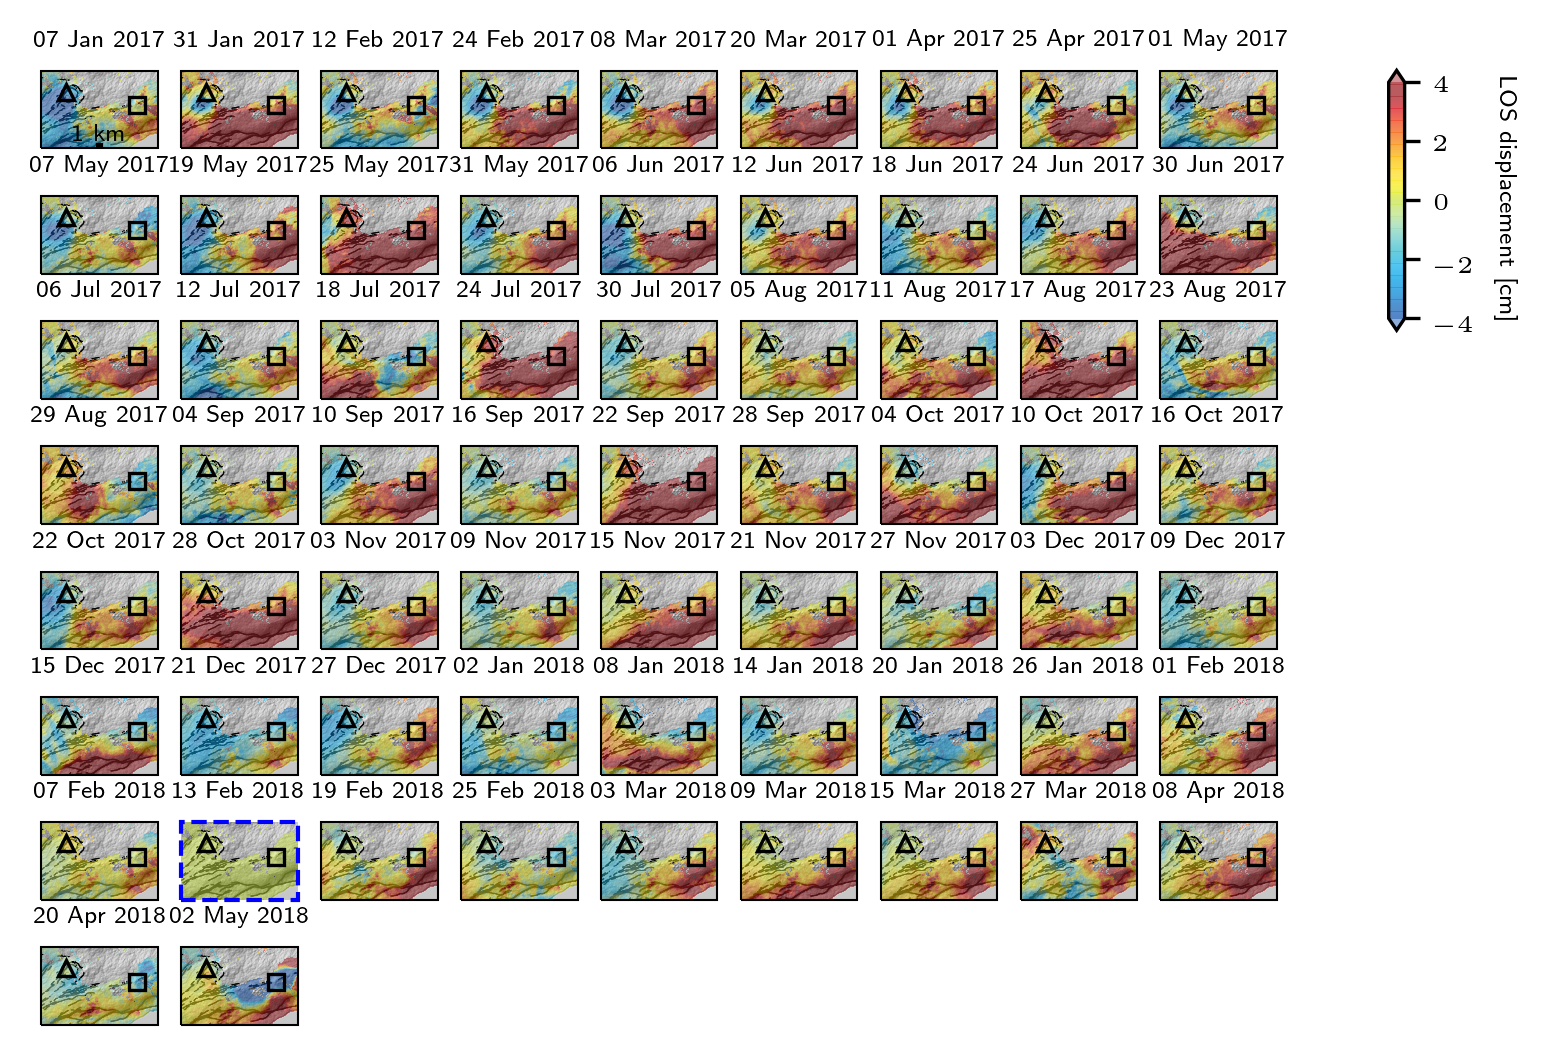

In [48]:
'''
Plot displacement from Sentinel [Asc] prior to and after eruption
'''
fig = plt.figure(figsize=mm2inch(135, 110), dpi = 300) ## initiate figure
matplotlib.rc('text', usetex = True)
axs = []
# for num in range(20):
#     axs.append(plt.subplot(4,5,num+1,
#     projection=ccrs.PlateCarree())
#           )
for num in range(65):
    axs.append(plt.subplot(8,9,num+1,
    projection=ccrs.PlateCarree())
          )
W, N, E, S = (-155.35, 19.475, -155.05, 19.275)
ocean_10m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                        edgecolor='face',
                                        facecolor="w")
for i in range(len(inps_.dset)):
    ax=axs[i]    
    subset = inps_.dset[i][-8::]
    cmd =  'view.py {} {} '.format(ts_file_asc, subset)
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c {} --nocbar --vlim -4 4 --alpha .5 '.format('temperature')
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(srtm)
    cmd += '--noscalebar --notitle --fontsize 8 --ref-size 1 --noverbose'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    date = '{2} {1} {0}'.format(subset[0:4],
                                  calendar.month_abbr[int(subset[4:6])],subset[6:])
    ax.set_title("{}".format(date), fontsize = "xx-small", ha="center")
    ax.plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='k', mfc='none', mew=0.8)
    ax.plot(pu_lalo[1], pu_lalo[0],'s', ms=4, mec='k', mfc='none', mew=0.8)
#     ax.coastlines(resolution='10m', color='k', linewidth=.5, zorder = 4)

    faults.plot(ax = ax, marker = ".",markersize=0.25, color = "k",edgecolor = "None", zorder = 1, alpha = 0.5)
    if i == 0:
        scale_bar(ax,1,fontsize = "xx-small")
    if inps_.dset[i][-8::] == atr["REF_DATE"]:
        ax.outline_patch.set_edgecolor("b")
        ax.outline_patch.set_linestyle("--")
    else:
        ax.outline_patch.set_linewidth(.5)
#     print("{}/{}".format(i+1, len(inps_.dset)))
        

for ax in axs:    
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x))
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(-x))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.xaxis.set_major_formatter(ticks_x)
    ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")

cax_ = fig.add_axes([0.97, 0.67, 0.01, 0.2])
cbar_ = plt.colorbar(im, cax=cax_, extend = "both")
cbar_.ax.tick_params(labelsize="xx-small")
ticks_cb = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
cax_.xaxis.set_major_formatter(ticks_cb)
cbar_.set_label('LOS displacement [cm]',
               fontsize="xx-small", rotation = 270, labelpad = 10)
# lw = 1
# offset1 = transforms.ScaledTranslation(-lw/72./2., 0, fig.dpi_scale_trans)
# trans1 = transforms.blended_transform_factory(
#     axs[0].transAxes +offset1, fig.transFigure)
# l1 = matplotlib.lines.Line2D([1.15,1.15], [.17, .25], transform=trans1, #1.12
#             figure=fig, color="grey",ls="--", linewidth=1, zorder=0)
# fig.lines.extend([l1]) 

#### Figure 1: Sentinel Ascending track data for dates from 07 Jan 2017 to 02 May 2018. #### 
Triangle = Kilauea summit; sqaure = Pu'u 'O'ō. Blue dashed bounding box indicates the reference date.


In [51]:
fig = plt.figure(figsize=mm2inch(135, 135), dpi = 300) ## initiate figure
matplotlib.rc('text', usetex = True)
axs = []
for num in range(72):
    axs.append(plt.subplot(8,9,num+1,
    projection=ccrs.PlateCarree())
          )
# plt.clf()
cmd_ = 'view.py {} --noverbose --nodisplay'.format(ts_file_desc)
_, _ ,inps_ = view.prep_slice(cmd_)
for i, dset in enumerate(inps_.dset):
    subset = dset[-8::]
    ax = axs[i]
    cmd =  'view.py {} {} '.format(ts_file_desc, subset)
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c inferno --nocbar --vlim -10 10 '
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(srtm)
    cmd += '--noscalebar --notitle --fontsize 12 --ref-size 2 --noverbose'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

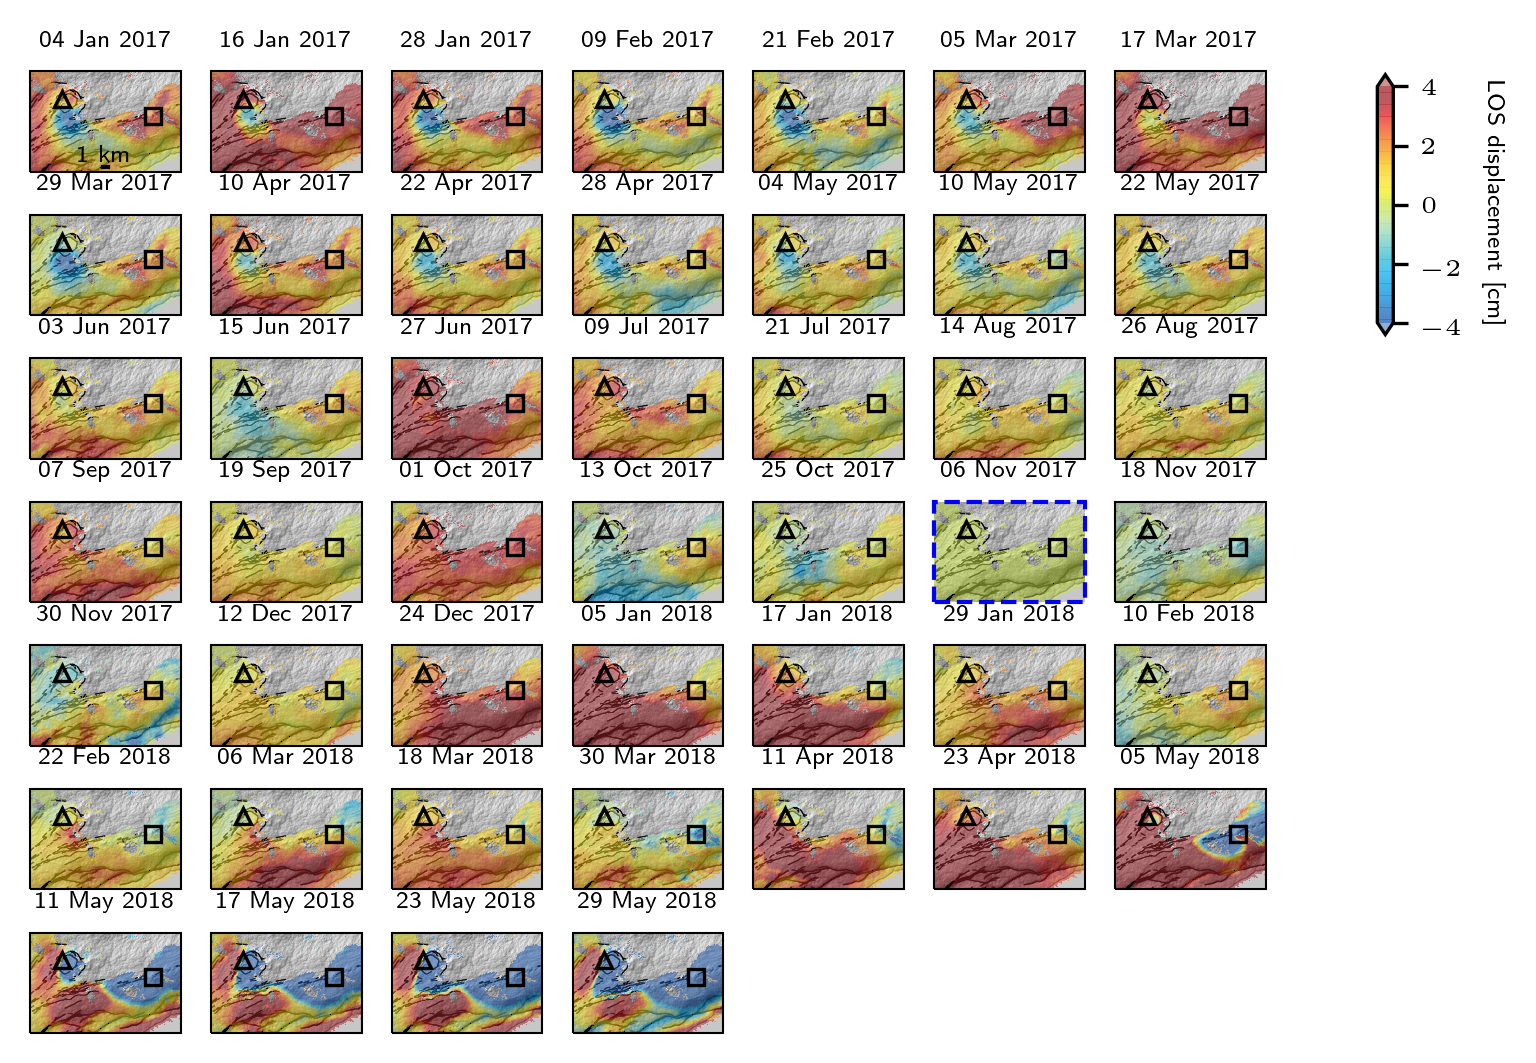

In [54]:
'''
Plot displacement from Sentinel [Desc] prior to and after eruption
'''
fig = plt.figure(figsize=mm2inch(135, 110), dpi = 300) ## initiate figure
matplotlib.rc('text', usetex = True)
axs = []
# for num in range(20):
#     axs.append(plt.subplot(4,5,num+1,
#     projection=ccrs.PlateCarree())
#           )
for num in range(46):
    axs.append(plt.subplot(7,7,num+1,
    projection=ccrs.PlateCarree())
          )
# W, N, E, S = (-155.5, 20, -154.800113373004, 18.95) # cardinal coords # 19.275 19.475 --sub-lon -155.35 -155.05
W, N, E, S = (-155.35, 19.475, -155.05, 19.275)
# W, N, E, S = (-155.12, 19.41, -155.08, 19.37) ## around pu'u'o'o
# W, N, E, S = (lon_volc-0.02, lat_volc+0.02, lon_volc+0.02, lat_volc-0.02) ## around summit lat_volc, lon_volc
# W, N, E, S = (pu_lalo[1]-0.08, pu_lalo[0]+0.05, pu_lalo[1]+0.05, pu_lalo[0]-0.05)

# --sub-lat 19.37 19.41 --sub-lon -155.12 -155.08
ocean_10m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                        edgecolor='face',
                                        facecolor="w")
for i in range(len(inps_.dset)):
    ax=axs[i]    
    subset = inps_.dset[i][-8::]
    cmd =  'view.py {} {} '.format(ts_file_desc, subset)
    cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
    cmd += '-c {} --nocbar --vlim -4 4 --alpha .5 '.format('temperature')
    cmd += '--dem {} --dem-nocontour --shade-min -4500 --shade-max 5000 '.format(srtm)
    cmd += '--noscalebar --notitle --fontsize 8 --ref-size 1 --noverbose'

    d_v, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
    date = '{2} {1} {0}'.format(subset[0:4],
                                  calendar.month_abbr[int(subset[4:6])],subset[6:])
    ax.set_title("{}".format(date), fontsize = "xx-small", ha="center")
    ax.plot(kil_lalo[1], kil_lalo[0],'^', ms=4, mec='k', mfc='none', mew=0.8)
    ax.plot(pu_lalo[1], pu_lalo[0],'s', ms=4, mec='k', mfc='none', mew=0.8)
#     ax.coastlines(resolution='10m', color='k', linewidth=.5, zorder = 4)

    faults.plot(ax = ax, marker = ".",markersize=0.25, color = "k",edgecolor = "None", zorder = 1, alpha = 0.5)
    if i == 0:
        scale_bar(ax,1,fontsize = "xx-small")
    if inps_.dset[i][-8::] == atr["REF_DATE"]:
        ax.outline_patch.set_edgecolor("b")
        ax.outline_patch.set_linestyle("--")
    else:
        ax.outline_patch.set_linewidth(.5)
#     print("{}/{}".format(i+1, len(inps_.dset)))
        

for ax in axs:    
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x))
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(-x))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.xaxis.set_major_formatter(ticks_x)
    ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")

cax_ = fig.add_axes([0.97, 0.67, 0.01, 0.2])
cbar_ = plt.colorbar(im, cax=cax_, extend = "both")
cbar_.ax.tick_params(labelsize="xx-small")
ticks_cb = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x))
cax_.xaxis.set_major_formatter(ticks_cb)
cbar_.set_label('LOS displacement [cm]',
               fontsize="xx-small", rotation = 270, labelpad = 10)
# lw = 1
# offset1 = transforms.ScaledTranslation(-lw/72./2., 0, fig.dpi_scale_trans)
# trans1 = transforms.blended_transform_factory(
#     axs[0].transAxes +offset1, fig.transFigure)
# l1 = matplotlib.lines.Line2D([1.15,1.15], [.17, .25], transform=trans1, #1.12
#             figure=fig, color="grey",ls="--", linewidth=1, zorder=0)
# fig.lines.extend([l1]) 

#### Figure 2: Sentinel Descending track data for dates from 04 Jan 2017 to 29 May 2018. #### 
Triangle = Kilauea summit; sqaure = Pu'u 'O'ō. Blue dashed bounding box indicates the reference date.


In [45]:
work_dir = !{pwd}
work_dir = work_dir[1]

In [ ]:
'''
GPS data accessed from Nevada Geodetic Laboratory
'''
### Summit stations
!wget --output-document OUTL.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/OUTL.tenv3"
!wget --output-document NPIT.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/NPIT.tenv3"
!wget --output-document CRIM.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/CRIM.tenv3"
!wget --output-document AHUP.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/AHUP.tenv3"
!wget --output-document BYRL.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/BYRL.tenv3"
!wget --output-document CNPK.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/CNPK.tenv3"
!wget --output-document UWEV.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/UWEV.tenv3"
!wget --output-document KOSM.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/KOSM.tenv3"

### Mid stations
!wget --output-document NUPM.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/NUPM.tenv3"
!wget --output-document MMAU.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/MMAU.tenv3"
!wget --output-document MKAI.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/MKAI.tenv3"
!wget --output-document KTPM.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/KTPM.tenv3"

### Pu u O o stations

!wget --output-document OKIT.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/OKIT.tenv3"
!wget --output-document JCUZ.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/JCUZ.tenv3"
!wget --output-document PUOC.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/PUOC.tenv3"
!wget --output-document KAMO.csv "http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/KAMO.tenv3"

In [100]:
'''
Read in GPS data
'''
### Summit stations
OUTL = pd.read_csv("OUTL.csv",delimiter=r"\s+")
NPIT = pd.read_csv("NPIT.csv",delimiter=r"\s+")
CRIM = pd.read_csv("CRIM.csv",delimiter=r"\s+")
AHUP = pd.read_csv("AHUP.csv",delimiter=r"\s+")
BYRL = pd.read_csv("BYRL.csv",delimiter=r"\s+")
CNPK = pd.read_csv("CNPK.csv",delimiter=r"\s+")
UWEV = pd.read_csv("UWEV.csv",delimiter=r"\s+")
KOSM = pd.read_csv("KOSM.csv",delimiter=r"\s+")

### Mid stations
NUPM = pd.read_csv("NUPM.csv",delimiter=r"\s+")
MMAU = pd.read_csv("MMAU.csv",delimiter=r"\s+")
MKAI = pd.read_csv("MKAI.csv",delimiter=r"\s+")
KTPM = pd.read_csv("KTPM.csv",delimiter=r"\s+")

### Pu u O o stations
OKIT = pd.read_csv("OKIT.csv",delimiter=r"\s+")
JCUZ = pd.read_csv("JCUZ.csv",delimiter=r"\s+")
PUOC = pd.read_csv("PUOC.csv",delimiter=r"\s+")
KAMO = pd.read_csv("KAMO.csv",delimiter=r"\s+")

summit_stations = [OUTL, NPIT, CRIM, AHUP, BYRL, CNPK, UWEV, KOSM]
summit_names = ["OUTL", "NPIT", "CRIM", "AHUP", "BYRL", "CNPK", "UWEV", "KOSM"]
mid_stations = [NUPM, MMAU, MKAI, KTPM]
mid_names = ["NUPM", "MMAU", "MKAI", "KTPM"]
puuoo_stations = [OKIT, JCUZ, PUOC, KAMO]
puuoo_names = ["OKIT", "JCUZ", "PUOC", "KAMO"]

In [101]:
'''
Aggregate GPS data into dictionaries 
'''
summit_gps_dict = {}
gps_frames = summit_stations
frame_names = summit_names
for num, frame in enumerate(gps_frames):
    frame.name = frame_names[num]
for frame in gps_frames:
    frame_name = frame.name+"_data"
    string_dates = []
    for string in frame.YYMMMDD:
        string=str(string)
#         if type(string)=='str':
        string=string.replace("-","")
        if string[0:2] == '99':
            string_dates.append(datetime.strptime(("19"+string), '%Y%b%d'))
        else:
            string_dates.append(datetime.strptime(("20"+string), '%Y%b%d'
                                                     ) if string[0:2].isdigit() else datetime.strptime(
                ("200"+string), '%Y%b%d'))
    summit_gps_dict[frame_name] = pd.DataFrame({
        "date" : string_dates,
        "elev" : frame['u0(m)'],
        "up" : frame['____up(m)'],
        "error" : frame['sig_u(m)'],
        "north" : frame['_north(m)'],
        "n_error" : frame['sig_n(m)']
    })
mid_gps_dict = {}
gps_frames = mid_stations
frame_names = mid_names
for num, frame in enumerate(gps_frames):
    frame.name = frame_names[num]
for frame in gps_frames:
    frame_name = frame.name+"_data"
    string_dates = []
    for string in frame.YYMMMDD:
        string=str(string)
#         if type(string)=='str':
        string=string.replace("-","")
        if string[0:2] == '99':
            string_dates.append(datetime.strptime(("19"+string), '%Y%b%d'))
        else:
            string_dates.append(datetime.strptime(("20"+string), '%Y%b%d'
                                                     ) if string[0:2].isdigit() else datetime.strptime(
                ("200"+string), '%Y%b%d'))
    mid_gps_dict[frame_name] = pd.DataFrame({
        "date" : string_dates,
        "elev" : frame['u0(m)'],
        "up" : frame['____up(m)'],
        "error" : frame['sig_u(m)'],
        "north" : frame['_north(m)'],
        "n_error" : frame['sig_n(m)']
    })
puuoo_gps_dict = {}
gps_frames = puuoo_stations
frame_names = puuoo_names
for num, frame in enumerate(gps_frames):
    frame.name = frame_names[num]
for frame in gps_frames:
    frame_name = frame.name+"_data"
    string_dates = []
    for string in frame.YYMMMDD:
        string=str(string)
#         if type(string)=='str':
        string=string.replace("-","")
        if string[0:2] == '99':
            string_dates.append(datetime.strptime(("19"+string), '%Y%b%d'))
        else:
            string_dates.append(datetime.strptime(("20"+string), '%Y%b%d'
                                                     ) if string[0:2].isdigit() else datetime.strptime(
                ("200"+string), '%Y%b%d'))
    puuoo_gps_dict[frame_name] = pd.DataFrame({
        "date" : string_dates,
        "elev" : frame['u0(m)'],
        "up" : frame['____up(m)'],
        "error" : frame['sig_u(m)'],
        "north" : frame['_north(m)'],
        "n_error" : frame['sig_n(m)']
    })

#### The following cells define a series of notebook-specific functions for different figure panels or components thereof ####
They are neither efficient nor pretty.

In [54]:
buffer = [patheffects.withStroke(linewidth=1, foreground="white")] # path effect for adding outline to text

In [92]:
def plot_maps(axes):

    edge_offset = 0.04

    for i, axis in enumerate(axes):

        if i % 2 != 0:
            roi = "Pu`u `Ō`ō"
            W, N, E, S = (pu_lalo[1]-0.08, pu_lalo[0]+0.065, pu_lalo[1]+0.05, pu_lalo[0]-0.065)
            ref_lat = 19.36
            ref_lon = -155.06
            scale = 1#50 #500
            key_length = .1#5 # 50
            poly1 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                    facecolor='None', edgecolor = 'k', linestyle ="-", linewidth =.85)
            axis.outline_patch.set_edgecolor("k")
            axis.outline_patch.set_linestyle("-")

        else:
            roi = "Summit"
            W, N, E, S = kil_lalo[1]-.5*edge_offset, kil_lalo[0]+.5*edge_offset,\
            kil_lalo[1]+edge_offset, kil_lalo[0]-edge_offset
            ref_lat = 19.435
            ref_lon = -155.3
            scale = 1#200
            key_length = .1#10
            poly2 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                    facecolor='None', edgecolor = 'g', linestyle ="-", linewidth =.85)
            axis.outline_patch.set_edgecolor("g")
            axis.outline_patch.set_linestyle("-")

        if i in [0,1]:
            ref_date = "20180315"
            dif_date = "20180423"
            file = up_file
 

        elif i in [2,3]:
            ref_date = "20180423"
            dif_date = "20180426"

        else:
            ref_date = "20180426"
            dif_date = "20180430"

        year_frac = (dt.datetime(2018,4,23) - dt.datetime(2018,3,15)).days/365   
        ax = axis 
        if i <2:
            if i < 2:
                    cmd =  'view.py {} '.format(up_file)
            #         cmd += '-{} --ref-date {} '.format(dif_date, ref_date)
                    cmd += '-c {} --nocbar --alpha .5 '.format("temperature")
            else:
                cmd =  'view.py {} '.format(srtm)
                cmd += '-c {} --nocbar --alpha 0.0001 '.format("temperature")

            cmd += '--sub-lat {} {} --sub-lon {} {} '.format(S, N, W, E)
            cmd += '--vlim {} {} '.format(-(1/year_frac),1/year_frac)
            cmd += '--ref-lalo {} {} '.format(ref_lat, ref_lon)
            cmd += '--dem {} --dem-nocontour --shade-min -4000 --shade-max 5500 --shade-az 60 '.format(srtm)
            cmd += '--noscalebar --notitle --fontsize 12 --ref-size 2 --noverbose --no-tight-layout'

            d_v, atr, inps = view.prep_slice(cmd)
            if i < 2:
                ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps)
            else: 
                ax, inps, im_, cbar = view.plot_slice(ax, d_v, atr, inps)
        else:
            axis.set_extent([W,E, S, N])


        s_date = '{2} {1} {0}'.format(ref_date[0:4],
                                      calendar.month_abbr[int(ref_date[4:6])],ref_date[6:])
        e_date = '{2} {1} {0}'.format(dif_date[0:4],
                                      calendar.month_abbr[int(dif_date[4:6])],dif_date[6:])

        faults.plot(ax = ax, marker = ".",markersize=3, color = "k",edgecolor = "None", zorder = 10, alpha = 0.5)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(x))
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:.1f}'.format(-x))
        ax.yaxis.set_major_formatter(ticks_y)
        ax.xaxis.set_major_formatter(ticks_x)
        ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)


        ## GPS
        dis_n, dis_e, dis_u, gps_lats, gps_lons, gps_names = gps_vectors(ref_date+"_"+dif_date, (S, N, W, E))
        year_frac = (datetime.strptime(dif_date, '%Y%m%d')-datetime.strptime(ref_date, '%Y%m%d')).days
        dis_n = np.array([x/year_frac for x in dis_n])
        dis_e = np.array([x/year_frac for x in dis_e])
        dis_u = np.array([x/year_frac for x in dis_u])
    #     scale = 1
    #     key_length = np.max(np.abs(np.sqrt(dis_e**2 + dis_n**2)))/2#np.median(np.abs(np.sqrt(dis_e**2 + dis_n**2)))
    #     print(key_length*2)
        ## Horizontal
        if i == 3 or i == 5:
            key_length = .1
            scale = 2.5
        q  = ax.quiver(gps_lons, gps_lats, dis_e, dis_n,
                       zorder=10, units='width', pivot='tail',
                   color = "k", scale = scale, clip_on=False
                   )

        ax.quiverkey(q, X=0.1, Y=-0.05, U=key_length,
                 label='GPS = {:.1f} {}'.format(#"horizontal",
                                                   key_length,
    #                                                  inps.disp_unit
                                                   "cm/d"
                                                  ), angle=0, labelpos='E', coordinates='axes',
                 fontproperties={'size':'x-small'})
    #     ax.scatter(gps_lons, gps_lats,',', ms=5, mec='r', mfc='r', mew=0.8, zorder = 11)
        ax.plot(gps_lons, gps_lats,'o', ms=2, mec='k', mfc='w', mew=0.8, zorder = 5)
        for j, label in enumerate(gps_names):
            flip = 1 if gps_lons[j] <= -155.15 else -1
            ax.annotate(label, xy = (gps_lons[j], gps_lats[j]),fontsize = "xx-small", xycoords="data",
                        xytext = (10*flip,5*flip), textcoords = "offset points",
                       path_effects = buffer, arrowprops={'arrowstyle': '-','linestyle': '-',
                                                          'color' : "k", 'linewidth': 0.5,
                                  'shrinkA':0, 'shrinkB': 0,},zorder =10, va="center", ha="center", color = "k")

        scale_bar(ax,location=(0.75, 0.05), length=1,fontsize = "x-small")

        if i % 2 == 0:
            ax.annotate("{} - {}".format(s_date, e_date), xy = (-0.1, .5),
                    xycoords = "axes fraction", fontsize = "x-small", fontweight = "bold", path_effects = buffer,
                       rotation = 90, ha= "center", va="center")
    #     elif i % 2 == 1 and i < 4:
    #         draw_los_az(W-0.02, N-0.02,atr, r = 0.015, ax = ax)

        if i < 2:
            ax.set_title("{}".format(roi), fontsize = "x-small", ha="center")#, y=-0.04)
    return im

In [78]:
def plot_gps_timeseries(axis, stations, intrusion_dates):
    n=1
    for k, station in enumerate(stations):
        try:
            frame_name = station+'_data'
            frame = summit_gps_dict[frame_name]
            for num, intrusion in enumerate(intrusion_dates):
                offset1 = 0.2*abs(1-k)
                offset2 = 0.05*abs(2-num)
                preceding_weeks = 10
                following_weeks = 1

                ax1 = axis.twiny()
                if k == num == 0:
                    ax1.axvline(intrusion, ls="-", lw=1,alpha =.85, color="firebrick", zorder = 0)
                    ax1.axvspan("2018-Mar-15", "2018-Apr-23", alpha=0.25, color='lightgrey', zorder =-1)

                first_date, last_date = time_before_intrusion(intrusion_date=intrusion,\
                                                             preceding_weeks = preceding_weeks,\
                                                                         following_weeks=following_weeks)
                try:
                    if not (k ==1 and num ==0):
                        if frame.date[0].to_pydatetime() <= first_date: 
                            first = frame[frame.date == datetime.strftime(first_date,"%Y-%m-%d")].up.values
                        else:
                            first = frame.up[0]
        #                 try:
                        N = frame[frame.date == intrusion].index.values[0]+1
    #                     try:
                        displacement = frame[frame.date == intrusion].up.values[0]-frame[frame.date == first_date].up.values[0]

#                         print("+{:.2f}".format(displacement))
    #                     except:
    #                         continue
        #                 except:
        #                     continue
                        ax1.plot(frame.date[0:N],
                                     frame.up[0:N]-first+(offset1+offset2)
                                 ,lw=.5, color=["k", "dodgerblue", "r", "gold"][num],
                                zorder = 8, alpha = 0.85)
            #             if k == 0 and num == 0:
                        ax1.scatter(frame.date[0:N],
                                 frame.up[0:N]-first+(offset1+offset2),
                                marker = ["o", "s", "D", "v"][k], ec = ["k", "dodgerblue", "r", "gold"][num],
                                  s=6,lw=.5, alpha = .85, color = "w",clip_on=True,
                               zorder = 9, label = station)

                        if not k > 0 or num > 0:
                            ax1.axhline(0+offset1+offset2, ls="--", lw=.5,zorder = 6, color = "grey")

                except:
                    continue


                ax1.set_xlim(datetime.strftime(first_date,"%Y-%m-%d"),
                            datetime.strftime(last_date,"%Y-%m-%d"))  
                ax1.set_xticks([])
                ax1.set_ylim(ymin = -0.02, ymax=0.41)
                ax1_ = ax1.twiny()
                if not (k == 1 and num ==0):
                    ax1_.annotate("{}\n+{:.2f} cm".format(str(intrusion)[0:10],displacement*100),\
                                  xy = (0,0.01+offset1+offset2), xytext = (2,0),
                                        xycoords = "data", textcoords = "offset points",
                                              fontsize = "xx-small", fontweight = "bold",
                #                               arrowprops={'arrowstyle': '-|>', 'color' : "firebrick", 'linewidth': 0.5,
                #                                           'shrinkA':0,'shrinkB': 0},
                                             path_effects = buffer)

                ax1_.set_xticks(np.arange(-preceding_weeks,following_weeks+1,1))
                ticks_x = ticker.FuncFormatter(lambda x, pos: '{}'.format(-x))
                ax1_.xaxis.set_major_formatter(ticks_x)
                ax1_.xaxis.tick_bottom()
                for axis_ in[ax1, ax1_]:
                    axis_.spines["top"].set_visible(False)
                    axis_.spines["right"].set_visible(False)
                    axis_.spines["left"].set_visible(False)
                    axis_.tick_params(axis='both', labelsize= "small")
                    axis_.set_facecolor("none")


                if num !=2:
                    ax1_.set_xticks([])
                ax1_.set_xticklabels([])
#                 ax1_.set_xticks([])
                for axis_ in[ax1, ax1_]:
                    axis_.spines["bottom"].set_visible(False)
#                 else:
#                     ax1_.set_xlabel("Weeks before intrusion", fontsize = "x-small")
#                     ax1_.xaxis.set_label_position('bottom') 

                ax1_.xaxis.set_tick_params(labelsize="x-small")
#     axis_.yaxis.set_tick_params(labelsize="x-small")
                
                

                for axis_ in[ax1, ax1_ ,axis]:

                    axis_.spines["right"].set_visible(False)
#                     axis_.yaxis.set_tick_params(labelsize="x-small")

        except:
            continue

    axis.patch.set_edgecolor("None")

    axis.patch.set_facecolor("w")
    axis.patch.set_alpha(0)
    axis.set_xticks([])
#     axis.tick_params(axis='both', labelsize= "x-small")
#     ax1.tick_params(axis='both', labelsize= "x-small")
#     ax1_.tick_params(axis='both', labelsize= "x-small")

    axis.axvspan(-6.6,-1, alpha=0.25, color='lightgrey', zorder =1)
    axis.set_xlim(-10,1)

    axis.annotate("Station: {}".format(stations[0]), xy = (-9.5,.33), fontsize="x-small")
    axis.annotate("Station: {}".format(stations[1]), xy = (-9.5,.10), fontsize="x-small") 

    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.0f}'.format(x*100))
    axis.yaxis.set_major_formatter(ticks_y)

    axis.minorticks_on()

#     ax1_.set_ylabel("Vertical displacement [cm]", fontsize = "x-small")
#     ax1_.yaxis.set_label_position('left') 
#     ax0.set_ylabel("Length change [m]", fontsize = "x-small", )



In [79]:
def plot_vertical_profiles(axis, WNES, summit = True, key = True):
    
    W, N, E, S = WNES

    ref_date = ["20180423", "20180426"]
    dif_date = ["20180426", "20180430"]
    txt_offsets = [[(10,20), (10,20), (10,10), (10, 10), (-10,10), (-10,10)], 
        [(10,20), (-10,20), (10,10), (-10, 20), (-10,10), (-10,10),(5,15), (5,10)]]

    ax = axis
    for i in [0,1]:
        ix = 0 if summit else 1
        dis_n, dis_e, dis_u, gps_lats, gps_lons, gps_names = gps_vectors(ref_date[i]+"_"+dif_date[i], (S, N, W, E))
        year_frac = (datetime.strptime(dif_date[i], '%Y%m%d')-datetime.strptime(ref_date[i], '%Y%m%d')).days
        dis_n = np.array([x/year_frac for x in dis_n])
        dis_e = np.array([x/year_frac for x in dis_e])
        dis_u = np.array([x/year_frac for x in dis_u])
        s_date = '{2} {1} {0}'.format(ref_date[i][0:4],
                                      calendar.month_abbr[int(ref_date[i][4:6])],ref_date[i][6:])
        e_date = '{2} {1} {0}'.format(dif_date[i][0:4],
                                      calendar.month_abbr[int(dif_date[i][4:6])],dif_date[i][6:])

        ax.plot(gps_lons,[0]*len(gps_lons),'o', ms=2, mec='k', mfc='w', mew=0.8, zorder = 15)

        q  = ax.quiver(gps_lons,[0]*len(gps_lons), 
                       [0]*len(dis_u),
    #                    dis_e, 
                       dis_u,
                       zorder=10-i, units='width', pivot='tail',
                       color = ["r", "dodgerblue"][i], scale = [4,4][i], clip_on=True, lw=.5
                       )
        key_length = [.25, .25]
        if key:
            ax.quiverkey(q, X=0.1, Y=[.2, .1][i], U=key_length[i],
                 label='{:.2f} {}; {} $-$ {}'.format(#"horizontal",
                                                   key_length[i],
    #                                                  inps.disp_unit
                                                   "cm/d",
                                             s_date, e_date
                                                  ), angle=0, labelpos='E', coordinates='axes',
                 fontproperties={'size':'x-small'})
        ax.axhline(0, lw=.5, color="grey", zorder = 0)
    
        ax.set_xlim(W,E)#-155.255)
        ax.set_ylim(-.1,.1)
        ax.set_yticks([])
        ax.set_facecolor('None')
        
        if i == 1:
            for j, label in enumerate(gps_names):
#                 print(label)

                ax.annotate(label, xy = (gps_lons[j], 0),fontsize = "xx-small", xycoords="data",rotation = 0,
                            xytext = txt_offsets[ix][j], textcoords = "offset points",
                           path_effects = buffer, arrowprops={'arrowstyle': '-','linestyle': '-',
                                                              'color' : "k", 'linewidth': 0.5,
                                      'shrinkA':0, 'shrinkB': 0,},zorder =10, va="center", ha="center", color = "k")
            ax.set_xlabel("Longitude", fontsize = "x-small")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")
#         ln = 2  # Keeps every nth label
#         [l.set_visible(False) for (ix,l) in enumerate(ax.xaxis.get_ticklabels()) if ix % ln != 0]

In [80]:
def plot_baseline_timeseries(axis, baseline_list, intrusion_dates):

    bl_list = baseline_list    

    for num, intrusion in enumerate(intrusion_dates):
        for k in range(len(bl_list)):
            offset1 = 0.2*abs(1-k)
            offset2 = 0.05*abs(2-num)
            preceding_weeks = 10
            following_weeks = 1

            ax1 = axis.twiny()
            if k == num == 0:
                ax1.axvline(intrusion, ls="-", lw=1,alpha =.85, color="firebrick", zorder = 0)

            first_date, last_date = time_before_intrusion(intrusion_date=intrusion,\
                                                         preceding_weeks = preceding_weeks,\
                                                                     following_weeks=following_weeks)


            baseline_data = baselines(bl_list[k][0],bl_list[k][1],first_date, last_date)
            N = baseline_data[baseline_data.date == intrusion].index.values[0]+1
            try:
                displacement = baseline_data[baseline_data.date == intrusion].dist.values[0]\
                -baseline_data[baseline_data.date == first_date].dist.values[0]
            except:
                displacement = baseline_data[baseline_data.date == intrusion].dist.values[0]\
                -baseline_data[baseline_data.date == baseline_data.date.values[0]].dist.values[0]
            
            ax1.plot(baseline_data.date[0:N], baseline_data.dist[0:N]-baseline_data.dist[0]+offset1+offset2,#(0.05*abs(2-num)),
                       lw=.5, ls="-",color=["k", "dodgerblue", "r"][num], marker = ["D", "v", "^", "+"][k], 
                     mec = ["k", "dodgerblue", "r"][num], mfc = "w", mew = .5, ms = 2.5,
                        label = r"{}$-${} length change".format(bl_list[0][0], bl_list[0][1]),alpha = .85,
                        zorder = 9)
            ax1.axhline(0+offset1+offset2, ls="--", lw=.5, zorder = 6, color = "grey")

            ax1.set_xticks([])
            ax1.set_ylim(ymin =-0.02, ymax = 0.41)#, ymax = 0.41)
            ax1.set_xlim(datetime.strftime(first_date,"%Y-%m-%d"),
                        datetime.strftime(last_date,"%Y-%m-%d")) 

            ax1_ = ax1.twiny()

            ax1_.annotate("{}\n+{:.1f} cm".format(str(intrusion)[0:10],displacement*100),\
                          xy = (0,0.01+offset1+offset2), xytext = (2,0),
                            xycoords = "data", textcoords = "offset points",
                                  fontsize = "xx-small", fontweight = "bold",
    #                               arrowprops={'arrowstyle': '-|>', 'color' : "firebrick", 'linewidth': 0.5,
    #                                           'shrinkA':0,'shrinkB': 0},
                                 path_effects = buffer)
            ax1_.set_xticks(np.arange(-preceding_weeks,following_weeks+1,1))
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{}'.format(-x))
            ax1_.xaxis.set_major_formatter(ticks_x)
            ax1_.xaxis.tick_bottom()
            for axis_ in[ax1, ax1_]:
                axis_.spines["top"].set_visible(False)
                axis_.spines["right"].set_visible(False)
                axis_.spines["left"].set_visible(False)
                
                axis_.tick_params(axis='both', labelsize= "small")
                axis_.set_facecolor("none")
                axis_.patch.set_alpha(0)


            if num !=2:
                ax1_.set_xticks([])
            ax1_.set_xticklabels([])
            for axis in[ax1, ax1_]:
                axis.spines["bottom"].set_visible(False)

#             else:
#                 ax1_.set_xlabel("Weeks before intrusion", fontsize = "x-small")
#                 ax1_.xaxis.set_label_position('bottom') 

            ax1_.xaxis.set_tick_params(labelsize="x-small")
            ax1.yaxis.set_tick_params(labelsize="x-small")
            for axis_ in[ax1, ax1_ ,axis]:
                axis_.spines["right"].set_visible(False)

            ax1_.set_xlim(-10,1)


    axis.patch.set_edgecolor("None")

    axis.patch.set_alpha(0)
    axis.set_xticks([])
    axis.tick_params(axis='both', labelsize= "small")

    axis.axvspan(-6.6,-1, alpha=0.25, color='lightgrey', zorder =1)
    axis.set_xlim(-10,1)


    axis.annotate(r"AHUP$-$UWEV", xy = (-9.5,.33), fontsize="x-small")
    axis.annotate(r"KTPM$-$NUPM", xy = (-9.5,.12), fontsize="x-small") 

    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.0f}'.format(x*100))
    axis.yaxis.set_major_formatter(ticks_y)

    axis.minorticks_on()

    axis.set_ylabel("Length change [cm]", fontsize = "x-small")




In [81]:
def time_before_intrusion(intrusion_date,preceding_weeks=4,following_weeks=1):
    delta = timedelta(weeks=preceding_weeks)
    zero_date = intrusion_date
    start_date = zero_date-delta
    end_date = zero_date+timedelta(weeks=following_weeks)
#     int_dates = np.linspace(-preceding_weeks,following_weeks, len(frame.up[::n]-first))
    
    return start_date, end_date

In [82]:
def read_data(sitename,time1,time2):
    filename=sitename+'.csv'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=pd.DataFrame(index=index);dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                    (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=pd.concat([dfin['YYMMMDD'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    dataval=dataval.set_index(['date'])
    dataval=dataval.resample('D').interpolate(method='linear')
    dataval=dataval.reset_index()

    return dataval

def baselines(site1,site2,time1,time2):
    dataval1=read_data(site1,time1,time2);dataval2=read_data(site2,time1,time2);
    merged=pd.merge(dataval1,dataval2,how='inner',on=['date'])
    merged['dist']=((merged['east_x']-merged['east_y'])**2+(merged['north_x']-merged['north_y'])**2)**0.5;
    return merged[['date','dist']]

In [83]:
'''
In order to replicate data from Poland et al. their figure has been digitised via [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).
It would of course be better to use the original data if they become available.
'''
Poland_data = pd.read_csv("https://raw.githubusercontent.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/master/data/Poland_length_data.csv", header=None, names = ["date","dist"])
dates = []
for date in Poland_data.date:
    dates.append(datetime.strptime(date, "%Y/%m/%d"))
Poland_data["dates"] = dates

In [88]:
def compare_timeseries(axis):
    
    ############################################################
    ktpm_nupm = baselines("KTPM", "NUPM",dt.date(2018, 1, 1), dt.date(2018, 5, 1))
    ax0 = axis
    
    intrusion = dt.date(2018, 4, 30)
    preceding_weeks = 10
    following_weeks = 1
    
    ax0.axvline(intrusion, ls="-", lw=1,alpha =.85, color="firebrick", zorder = 0)
    ax0.plot(ktpm_nupm.date,ktpm_nupm.dist-ktpm_nupm.dist[0],lw=.5, color="r", clip_on=True,
             marker = "v", ms= 2.5, mfc="w", mew=.5, alpha = .85)
    
    first_date, last_date = time_before_intrusion(intrusion_date=intrusion,\
                                                             preceding_weeks = preceding_weeks,\
                                                                         following_weeks=following_weeks)
    for num, axis_ in enumerate([ax0]):
        axis_.set_ylim(-.005,.02) 
        axis_.axhline(0, ls = "--", lw=.5, zorder = 0, color = "grey")
        axis_.spines['top'].set_visible(False)
        axis_.spines['right'].set_visible(False)
        axis_.tick_params(axis='both', labelsize= "x-small")
        axis_.set_facecolor("none")
        months = mdates.MonthLocator()
        axis_.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        axis_.xaxis.set_major_locator(months)
        
    #     [l.set_visible(False) for (i,l) in enumerate(axis.xaxis.get_ticklabels()) if i % ln != 0]
    ax0.set_xlim("2018-01-01", "2018-05-01")

    n  = 85
    ax0.plot(Poland_data.dates[0:n], Poland_data.dist[0:n]*1+.002, color = "k", lw = .5, zorder = 10,# marker =".", ms=1, 
            label = "Poland et al.")
    ax0.plot(Poland_data.dates[n::], Poland_data.dist[n::]*1+.002, color = "k", lw = .5, zorder = 10, #marker =".", ms=1, 
            label = "_nolegend")
    ax0.plot(Poland_data.dates[n-1:n+1], Poland_data.dist[n-1:n+1]*1+.002, color = "k", ls = "--",
             lw = .5, zorder = 10, #marker =".", ms=1, 
            label = "_nolegend")
    ax0.legend(fancybox=False, loc = "center left", fontsize = "xx-small", facecolor = "None", edgecolor = "None",
    #           bbox_to_anchor= (0,-.5)
              )
    ax0.set_xticks([])
    ax0.set_xlim(datetime.strftime(first_date,"%Y-%m-%d"),
                datetime.strftime(last_date,"%Y-%m-%d")) 
    ax0_ = ax0.twiny()
    ax0_.set_xticks(np.arange(-preceding_weeks,following_weeks+1,1))
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{}'.format(-x))
    ax0_.xaxis.set_major_formatter(ticks_x)
    ax0_.xaxis.tick_bottom()
    for axis in[ax0, ax0_]:
    #     axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.tick_params(axis='both', labelsize= "small")
        axis.set_facecolor("none")
    ax0.yaxis.tick_left()
    ax0_.xaxis.set_tick_params(labelsize="x-small")
    ax0.yaxis.set_tick_params(labelsize="x-small")
    ax0_.set_xlim(-10,1)
    ax0_.set_xlabel("Weeks before intrusion", fontsize = "x-small")
    ax0_.xaxis.set_label_position('bottom') 
    ax0.yaxis.set_label_position('left') 
    ax0.set_ylabel("Length change [cm]", fontsize = "x-small", )
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:.0f}'.format(x*100))
    ax0.yaxis.set_major_formatter(ticks_y)
    

### Plot Figure ###
If user encounters ```HTTP Error 404: Not Found``` try copying GPS .txt files into working directory from:

https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180315_20180423.txt https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180423_20180426.txt https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180426_20180430.txt

In [ ]:
!wget -nv -O GPS_kilauea_20180315_20180423.txt 'https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180315_20180423.txt?download=1' -nc -c  
!wget -nv -O GPS_kilauea_20180423_20180426.txt 'https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180423_20180426.txt?download=1' -nc -c  
!wget -nv -O GPS_kilauea_20180426_20180430.txt 'https://github.com/jifarquharson/Farquharson_Amelung_2020_Kilauea-Nature/blob/master/gps_data/GPS_kilauea_20180426_20180430.txt?download=1' -nc -c  

reading GPS displacement between 20180315 and 20180423 ...
reading GPS displacement between 20180315 and 20180423 ...
reading GPS displacement between 20180423 and 20180426 ...
reading GPS displacement between 20180423 and 20180426 ...
reading GPS displacement between 20180426 and 20180430 ...
reading GPS displacement between 20180426 and 20180430 ...
reading GPS displacement between 20180423 and 20180426 ...
reading GPS displacement between 20180426 and 20180430 ...
reading GPS displacement between 20180423 and 20180426 ...
reading GPS displacement between 20180426 and 20180430 ...


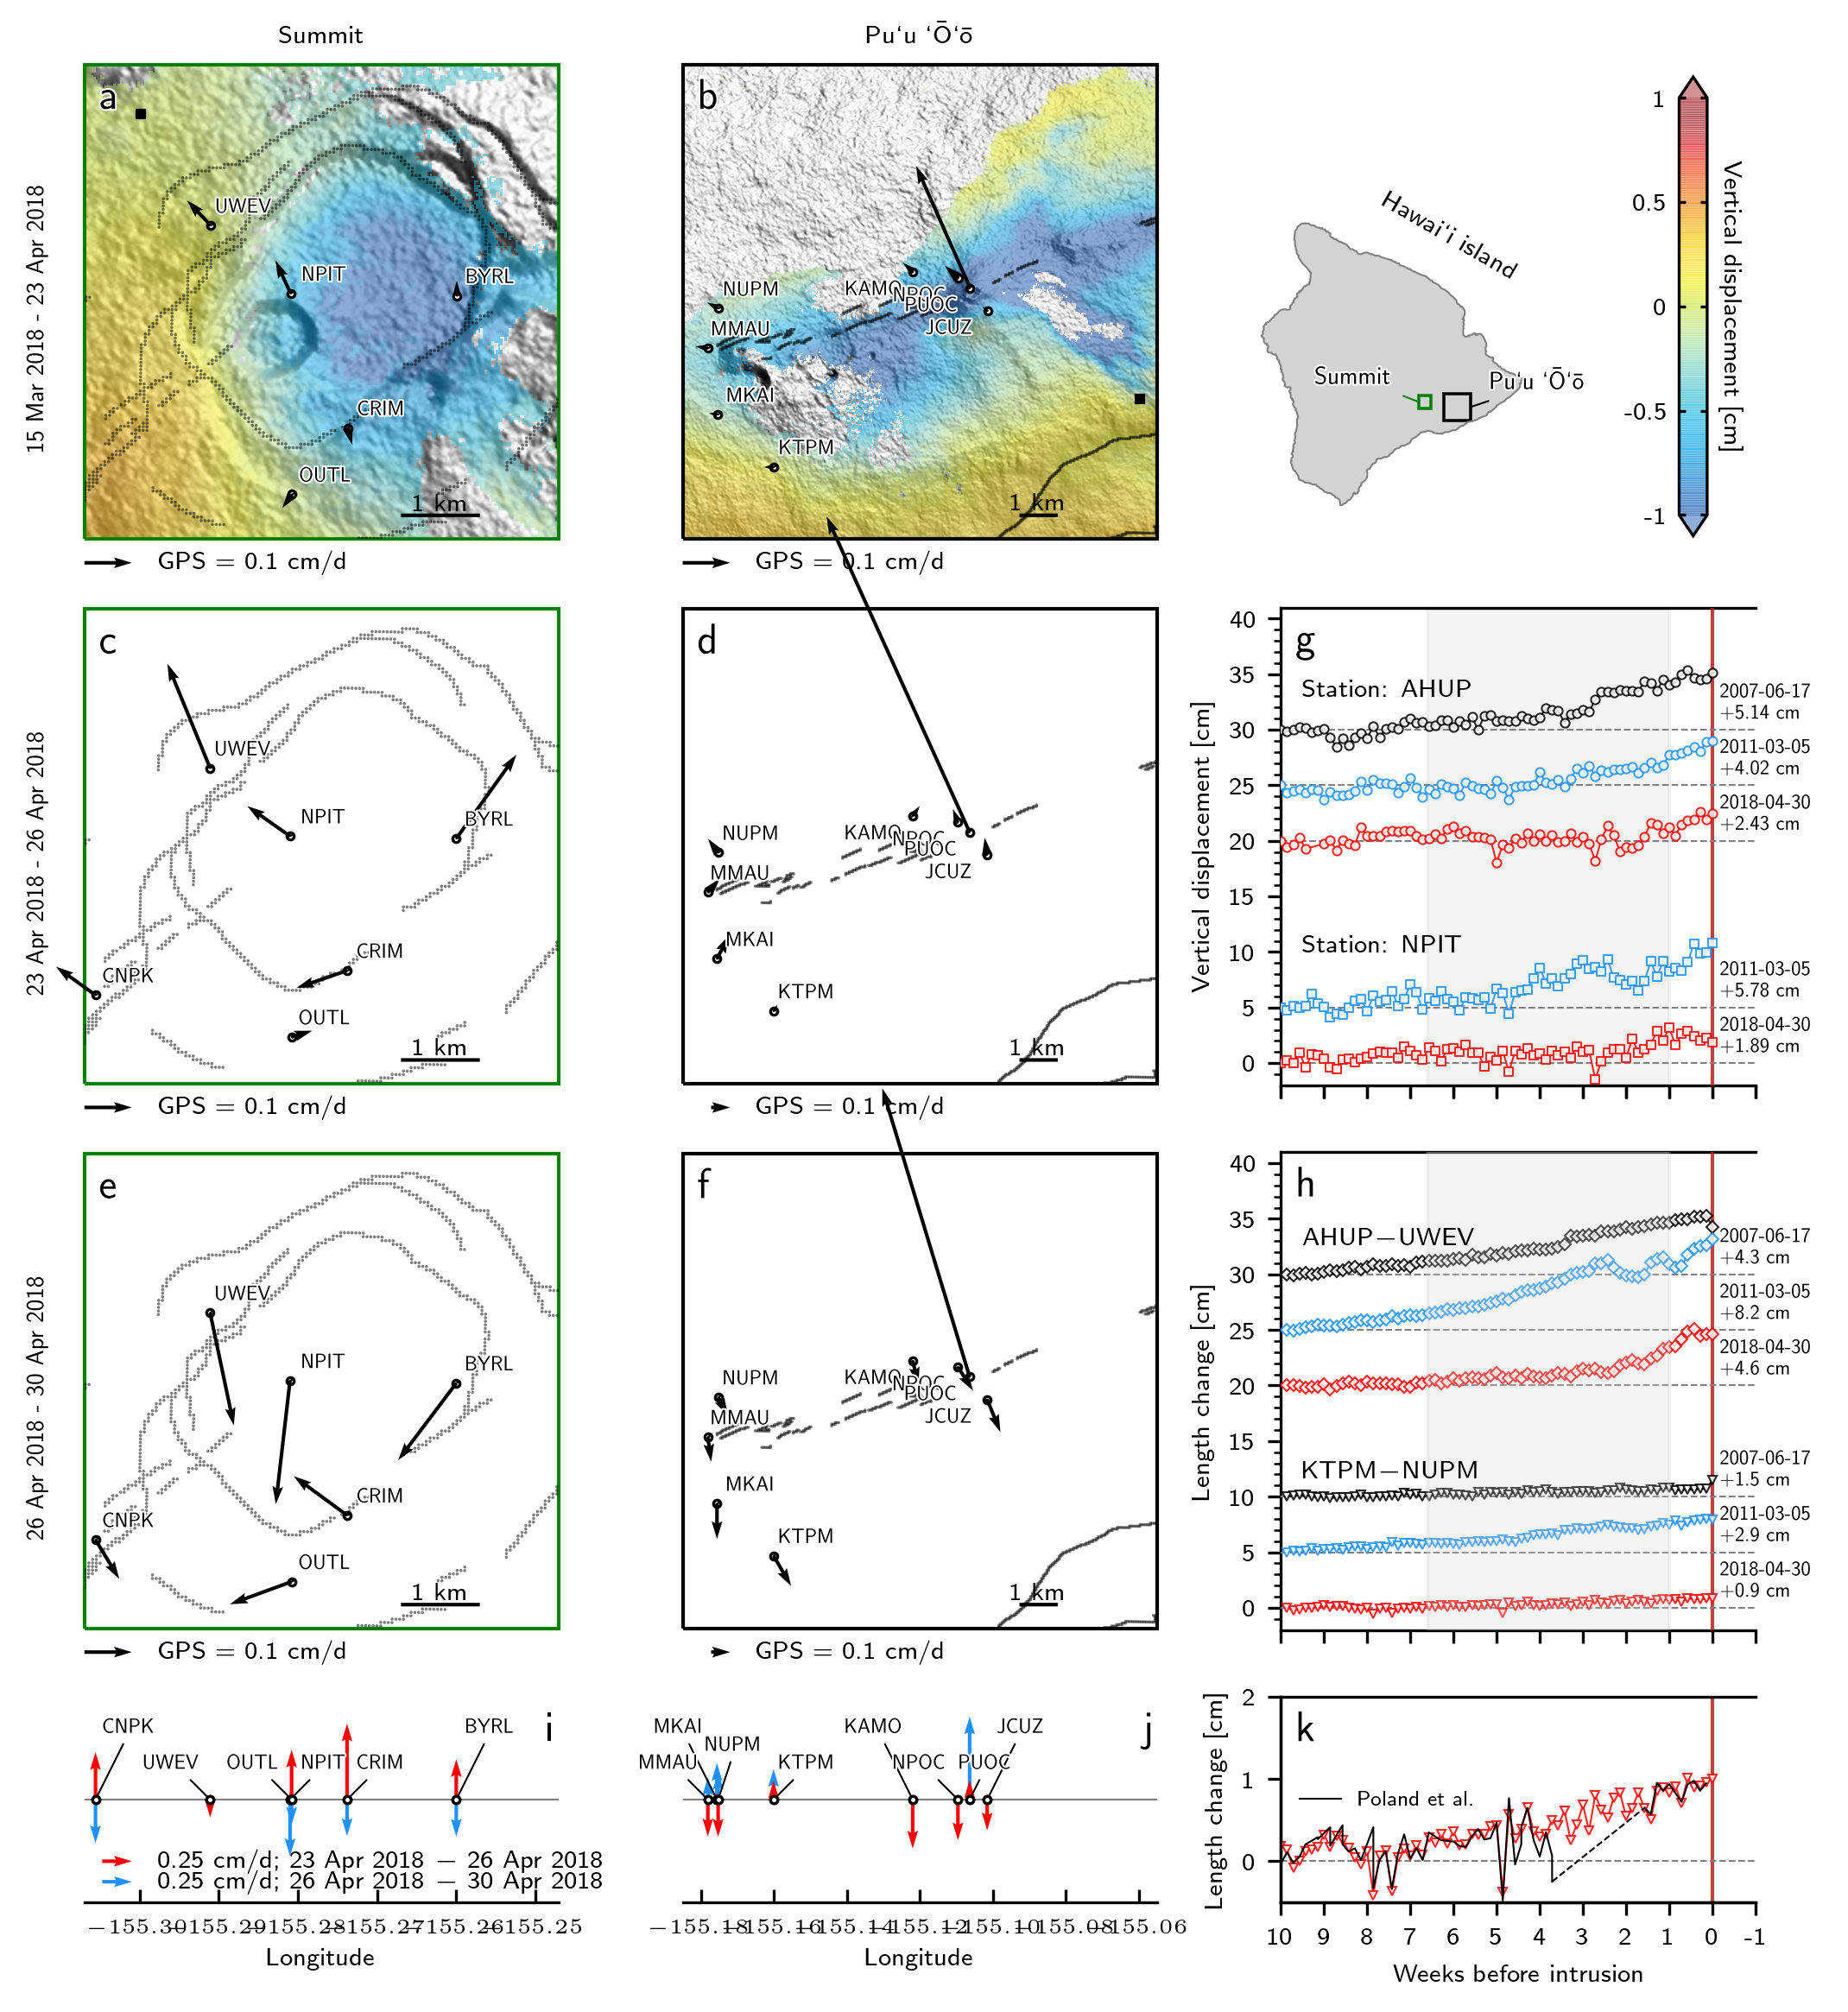

In [103]:
fig = plt.figure(1, figsize=(mm2inch(183,200)), frameon=True, dpi=300)  ### max size (183,247)
axs = [plt.subplot2grid((7, 3), (0, 0), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #a 0
       plt.subplot2grid((7, 3), (0, 1), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #b 1
       plt.subplot2grid((7, 3), (2, 0), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #c 2
       plt.subplot2grid((7, 3), (2, 1), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #d 3
       plt.subplot2grid((7, 3), (4, 0), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #e 4
       plt.subplot2grid((7, 3), (4, 1), rowspan = 2, colspan = 1,  projection=ccrs.PlateCarree()), #f 5
] ### map axes
axs.extend([plt.subplot2grid((7, 3), (2, 2), rowspan = 2, colspan = 1,), #g 6
           plt.subplot2grid((7, 3), (4, 2), rowspan = 2, colspan = 1,),  #h 7
           ]) ## GPS time series axes

axs.extend([plt.subplot2grid((7, 3), (6, 0), rowspan = 1, colspan = 1,), #i 8
           plt.subplot2grid((7, 3), (6, 1), rowspan = 1, colspan = 1,),  #j 9
           ]) ## Vertical gps profile axes

axs.append(plt.subplot2grid((7, 3), (6, 2), rowspan = 1, colspan = 1,)   #k 10
          ) ## Comparison axis


############## Plot InSAR and GPS in map view for three different date ranges ##############
im = plot_maps(axs[0:6])        
print("maps plotted")
############## Plot vertical GPS profile for two different date ranges #####################
##### summit
edge_offset = 0.04
plot_vertical_profiles(axs[8],(kil_lalo[1]-.5*edge_offset, kil_lalo[0]+.5*edge_offset,\
        kil_lalo[1]+edge_offset, kil_lalo[0]-edge_offset))

############## Plot vertical GPS profile for two different date ranges #####################
##### Pu`u `O`o
plot_vertical_profiles(axs[9],(pu_lalo[1]-0.08, pu_lalo[0]+0.065, pu_lalo[1]+0.05, pu_lalo[0]-0.065),
                       summit=False, key=False)
print("verticals plotted")
############## Plot vertical GPS timeseries prior to intrusions ############################
baseline_list = [("AHUP", "UWEV"), ("KTPM", "NUPM")]
intrusion_dates = [dt.datetime(2007, 6, 17), dt.datetime(2011, 3, 5), dt.datetime(2018, 4, 30)]

plot_gps_timeseries(axs[6], ["AHUP","NPIT"], intrusion_dates)
print("timeseries plotted")
############## Plot baseline GPS timeseries prior to intrusions ############################
plot_baseline_timeseries(axs[7], baseline_list, intrusion_dates)
print("baselines plotted")
for j in [6,7]:
    axs[j].set_xticks([])
    axs[j].spines["right"].set_visible(False)
    axs[j].tick_params(axis='both', labelsize= "x-small")
    
axs[6].set_ylabel("Vertical displacement [cm]", fontsize = "x-small")
axs[7].set_ylabel("Length change [cm]", fontsize = "x-small")
    

############## Compare baseline data to Poland et al. baseline displacement ###############
compare_timeseries(axs[10])
print("comparison plotted")
############## Inset map ##################################################################
mapax_ = fig.add_axes([.65, 0.65, 0.2, 0.34])
m = Basemap(llcrnrlon=-156.3,
            llcrnrlat=18.9,
            urcrnrlon=-154.5,
            urcrnrlat=20.4,
            projection='cyl',
            resolution = 'h',
            area_thresh=110,
            ax=mapax_)
m.drawcoastlines(linewidth = .5, color = 'grey')

m.fillcontinents(color='lightgrey')

W, N, E, S = (pu_lalo[1]-0.08, pu_lalo[0]+0.065, pu_lalo[1]+0.05, pu_lalo[0]-0.065)
poly1 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                facecolor='None', edgecolor = 'k', linestyle ="-", linewidth =.85)
mapax_.annotate("Pu`u `Ō`ō", xy=(E,(N+S)/2),xycoords= "data", fontsize = "x-small",
               xytext = (5,5), textcoords = "offset points",
               arrowprops={'arrowstyle': '-','linestyle': '-',
                                                      'color' : "k", 'linewidth': 0.5,
                              'shrinkA':0, 'shrinkB': 0,}, path_effects = buffer, )

mapax_.add_patch(poly1)
W, N, E, S = kil_lalo[1]-.5*edge_offset, kil_lalo[0]+.5*edge_offset,\
        kil_lalo[1]+edge_offset, kil_lalo[0]-edge_offset
mapax_.annotate("Summit", xy=(W,(N+S)/2),xycoords= "data", fontsize = "x-small",
               xytext = (-5,5), textcoords = "offset points",
               arrowprops={'arrowstyle': '-','linestyle': '-',
                                                      'color' : "g", 'linewidth': 0.5,
                              'shrinkA':0, 'shrinkB': 0,}, path_effects = buffer, ha = "right")
poly2 = Polygon([(E,N), (E,S), (W,S), (W,N)],
                facecolor='None', edgecolor = 'g', linestyle ="-", linewidth =.85)
mapax_.add_patch(poly2)
mapax_.axis('off')
mapax_.annotate("Hawai`i island", xy=(-155.5, 20),xycoords= "data", fontsize = "x-small", rotation = -30)



############## Colourbar ##################################################################
cax_ = fig.add_axes([.9, 0.73, 0.015, 0.225])
cbar_ = plt.colorbar(im, cax=cax_, extend = "both")
cbar_.ax.tick_params(labelsize="x-small", length = 2)
year_frac = (dt.datetime(2018,4,23) - dt.datetime(2018,3,15)).days/365
ticks_cb = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*year_frac))
cax_.yaxis.set_major_formatter(ticks_cb)

cb_ticks = np.linspace(-1/year_frac, 1/year_frac, 5)
cb_labels = [-1,-.5,0,.5,1]
cbar_.set_ticks(cb_ticks)
cbar_.set_ticklabels(cb_labels)
cbar_.ax.yaxis.tick_left()
cbar_.ax.yaxis.set_ticks_position('both')
cbar_.ax.tick_params(which='both', direction='in', bottom=True, top=True)
cbar_.set_label('Vertical displacement [cm]',
               fontsize="x-small", rotation = 270, labelpad = 10)

############## Labels ####################################################################
for num in range(len(axs)):
    a = 0 if num not in [8,9] else 1
    b = 4 if num not in [8,9] else -4
    axs[num].annotate(STRING.ascii_lowercase[num], (a, 1),xytext=(b, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = 1000)
plt.tight_layout()

#### Figure XX ####
Precursory ground deformation at Kīlauea. Vertical displacement rate determined from Sentinel-1 InSAR data (ascending track 124 and descending track 87) for 15 March 2018 to 23 April 2018 at (a) Kīlauea’s summit, and (b) the Pu‘u ‘Ō‘ō region. Horizontal GPS displacement over that time: vectors show direction (N, E, S, W) and relative rate of displacement. (c) Horizontal GPS displacement between 23 April and 26 April at the summit. (d) As (c), for the Pu‘u ‘Ō‘ō. region. (e) Horizontal GPS displacement between 26 April and 30 April at the summit. (f) As (e), for the Pu‘u ‘Ō‘ō. region. (g) GPS timeseries for stations AHUP and NPIT, showing the vertical displacement prior to intrusions in 2007, 2011, and 2018. Shaded area indicates the InSAR epoch in (a) and (b). Solid vertical line represents intrusion. Timeseries data are offset from x-axis for clarity. Annotations indicate intrusion dates and net displacement over the 10 weeks prior. h Line-length change between stations AHUP and UWEV (summit) and KTPM and NUPM (mid-rift), showing extensive displacement prior to intrusions in 2007, 2011, and 2018.  (i) Vertical GPS displacement at the summit between 23 and 26 April (red) and 26 and 30 April (blue). (j) As (i) for the Pu‘u ‘Ō‘ō. region. (k) detailed view of length change between KTPM and NUPM stations. 